# RANSAC (RANdom SAmple Consensus)

1. Select randomly the minimum number of points required to determine the model parameters.
2. Solve for the parameters of the model.
3. Determine how many points from the set of all points fit with a predefined tolerance e.
4. If the fraction of the number of inliers over the total number points in the set exceeds a predefined threshold τ , re-estimate the model parameters using all the identified inliers and terminate.
5. Otherwise, repeat steps 1 through 4 (maximum of N times).



### Generate data points

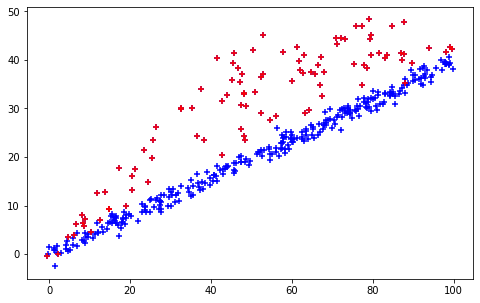

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
np.warnings.filterwarnings('ignore')

n_samples = 400
input_dim = 1
output_dim = 1

# generate perfect input data
A_exact = 100*np.random.random((n_samples,input_dim))
perfect_fit = np.random.normal(size=(input_dim,output_dim))
B_exact = scipy.dot(A_exact,perfect_fit)

# add small noise
A_noisy = A_exact + np.random.normal(size=A_exact.shape )
B_noisy = B_exact + np.random.normal(size=B_exact.shape )

# add some outliers
n_outliers = 100
dd = np.random.rand(n_outliers,input_dim)+0.2
C_noisy = B_noisy.mean()*dd*np.sin(0.03*A_noisy[0:n_outliers])
B_noisy[0:n_outliers] += C_noisy

plt.figure(figsize=[8,5])
plt.scatter(A_noisy, B_noisy, c='b', marker='+')
plt.scatter(A_noisy[0:n_outliers], B_noisy[0:n_outliers], c='r', marker='+');

### Linear Least Square Model

perfect fit = 0.3950
LLS fit = 0.4350


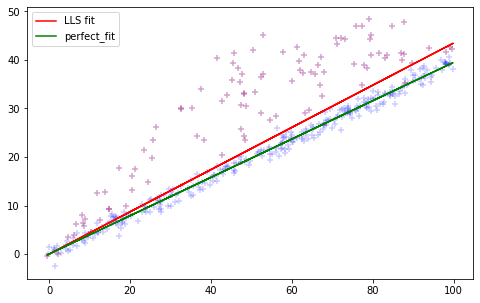

In [2]:
class LinearLeastSquaresModel:
    def __init__(self):
        pass
    def fit(self, data):
        A = data[:,0,None]
        B = data[:,1,None]
        x, _, _, _ = np.linalg.lstsq(A, B)
        return x
    def get_error(self, model, data):
        A = data[:,0,None]
        B = data[:,1,None]
        B_fit = np.dot(A, model)
        err_per_point = np.sum((B-B_fit)**2,axis=1)
        return err_per_point

data = np.hstack((A_noisy, B_noisy))
model = LinearLeastSquaresModel()
x = model.fit(data)
print("perfect fit = {:.4f}\nLLS fit = {:.4f}".format(perfect_fit[0][0], x[0][0]))

plt.figure(figsize=[8,5])
plt.scatter(A_noisy, B_noisy, c='b', marker='+', alpha=0.2)
plt.scatter(A_noisy[0:n_outliers], B_noisy[0:n_outliers], c='r', marker='+', alpha=0.2)
plt.plot(A_noisy, A_noisy.dot(x), c='r', label='LLS fit')
plt.plot(A_noisy, A_noisy.dot(perfect_fit), c='g', label='perfect_fit')
plt.legend();

### Our improved RANSAC
In step 1 and 2:
We select **some** (more than minimum) number of points. And use a **deterministic** method to solve the model.

##### Algorithm:
Given:
 - data - a set of observed data points
 - model - a model that can be fitted to data points
 - n - the minimum number of data values required to fit the model
 - k - the maximum number of iterations allowed in the algorithm
 - t - a threshold value for determining when a data point fits a model
 - d - the number of close data values required to assert that a model fits well to data

Return:
    bestfit - model parameters which best fit the data (or nil if no good model is found)

Process:
```
iterations = 0
bestfit = nil
besterr = something really large
while iterations < k {
    maybeinliers = n randomly selected values from data
    maybemodel = model parameters fitted to maybeinliers
    alsoinliers = empty set
    for every point in data not in maybeinliers {
        if point fits maybemodel with an error smaller than t
             add point to alsoinliers
    }
    if the number of elements in alsoinliers is > d {
        # this implies that we may have found a good model, now test how good it is
        bettermodel = model parameters fitted to all points in maybeinliers and alsoinliers
        thiserr = a measure of how well model fits these points
        if thiserr < besterr {
            bestfit = bettermodel
            besterr = thiserr
        }
    }
    increment iterations
}
return bestfit
```

In [3]:
def ransac(data,model,n,k,t,d,debug=False,return_all=False):
    
    """
    Function to evaluate estimated correspondences against ground truth.

    The evaluation requires 100 matches to receive full credit
    when num_req_matches=100 because we define accuracy as:

    Accuracy = (true_pos)/(true_pos+false_pos) * min(num_matches,num_req_matches)/num_req_matches

    Args:
    - data： a set of observed data points
    - model: a model that can be fitted to data points
    - n: the minimum number of data values required to fit the model
    - k: the maximum number of iterations allowed in the algorithm
    - t: a threshold value for determining when a data point fits a model
    - d: the number of close data values required to assert that a model fits well to data
    
    Return: Best model parameters.
    """
    
    def random_partition(n, n_data):
        all_index = np.arange(n_data)
        idx1 = np.random.choice(all_index, n, replace=False)
        idx2 = np.setdiff1d(all_index, idx1)
        return idx1, idx2

    iterations = 0
    bestfit = None
    besterr = np.inf
    best_inlier_idxs = None
    while iterations < k:
        maybe_idxs, test_idxs = random_partition(n,data.shape[0])
        maybeinliers = data[maybe_idxs,:]
        test_points = data[test_idxs]
        maybemodel = model.fit(maybeinliers)
        test_err = model.get_error(maybemodel, test_points)
        also_idxs = test_idxs[test_err < t] # select indices of rows with accepted points
        alsoinliers = data[also_idxs,:]
        if debug:
            print('test_err.min()',test_err.min())
            print('test_err.max()',test_err.max())
            print('np.mean(test_err)',np.mean(test_err))
            print('iteration {}:len(alsoinliers) = {}'.format(iterations,len(alsoinliers)))
        if len(alsoinliers) > d:
            betterdata = np.concatenate( (maybeinliers, alsoinliers) )
            bettermodel = model.fit(betterdata)
            better_errs = model.get_error(bettermodel, betterdata)
            thiserr = np.mean( better_errs )
            if thiserr < besterr:
                bestfit = bettermodel
                besterr = thiserr
                best_inlier_idxs = np.concatenate( (maybe_idxs, also_idxs) )
        iterations+=1
    if bestfit is None:
        raise ValueError("did not meet fit acceptance criteria")
    if return_all:
        return bestfit, {'inliers':best_inlier_idxs}
    else:
        return bestfit

perfect fit = 0.3950
LLS fit = 0.4350
RANSAC fit = 0.4012


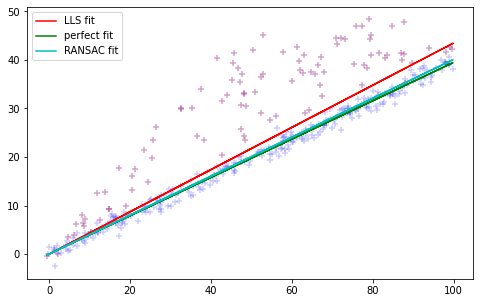

In [4]:
model = LinearLeastSquaresModel()
ransac_fit = ransac(data, model, n=50, k=300, t=30, d=200)

print("perfect fit = {:.4f}\nLLS fit = {:.4f}\nRANSAC fit = {:.4f}"
      .format(perfect_fit[0,0], x[0,0], ransac_fit[0,0]))

plt.figure(figsize=[8,5])
plt.scatter(A_noisy, B_noisy, c='b', marker='+', alpha=0.2)
plt.scatter(A_noisy[0:n_outliers], B_noisy[0:n_outliers], c='r', marker='+', alpha=0.2)
plt.plot(A_noisy, A_noisy.dot(x), c='r', label='LLS fit')
plt.plot(A_noisy, A_noisy.dot(perfect_fit), c='g', label='perfect fit')
plt.plot(A_noisy, A_noisy.dot(ransac_fit), c='c', label='RANSAC fit')
plt.legend();